In [1]:
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import copy
import math
import scipy.linalg
import scipy.signal
import operator
import sympy
import itertools

LETTERS = "ijklmnoprst"

def prod(iterable):
  return reduce(operator.mul, iterable, 1)

def without(list_, idx):
  return list_[:idx] + list_[idx+1:]

В данном ДЗ допускается использование циклов **только** по размерности массивов (и по итерациям, где они есть). 

# 1. Реализация ALS алгоритма для канонического тензорного разложения

В этой части задачи мы реализуем ALS алгоритм, который является популярным выбором в приложениях благодаря своей простоте и возможности адаптировать алгоритм к тензорам, имеющим дополнительную структуру (например, разреженность).

С помощью ```np.einsum``` напишите функцию, вычисляющую полный тензор $A$ по его каноническому разложению. Пользуйтесь ей при отладке дальнейшего кода.

## 1.1 Вспомогательные функции

In [2]:
def full(X):
  '''
  Input:
    X: X = (U1, U2, U3) - tuple of CP factors (numpy arrays)

  Output:
    A: 3d full tensor, constructed from its CP representation
  '''
  U1, U2, U3 = X
  return np.einsum('il, jl, kl -> ijk', U1, U2, U3)
  raise NotImplementedError()

In [3]:
U, V, W = np.ones((4, 2)), np.ones((5, 2)), np.ones((6, 2))
assert np.linalg.norm(full((U, V, W)) - 2 * np.ones((4, 5, 6))) == 0

Напишем теперь несколько вспомогательных функций

Используя ```np.einsum``` напишите функцию ```mttkrp``` (Matricized tensor times Khatri-Rao product), вычисляющую 
$$
  A_{(p)} (U^{(d)} \odot \dots \odot U^{(p+1)} \odot U^{(p-1)} \odot \dots \odot U^{(1)})
$$
для $d=3$ и $p=1,2,3$. Используйте ```np.einsum``` только один раз, заранее подготовив строку для правила суммирования.

In [4]:
def mttkrp(A, X, p):
  '''
  Input:
    A: 3D tensor
    X: a tuple of 2 numpy arrays: (U1, U2, U3), excluding the p-th matrix
    p: 0, 1 or 2

  Output:
    Up: 2D numpy array
  '''
  _A = np.moveaxis(A, p, 0)
  B, C  = X
  return np.einsum("ijk, jl, kl -> il", _A, B, C)
  raise NotImplementedError()

In [5]:
U, V, W = np.ones((4, 2)), np.ones((5, 2)), np.ones((6, 2))
A = np.ones((4, 5, 6))

assert np.linalg.norm(mttkrp(A, (V, W), 0) - 5*6*U) == 0
assert np.linalg.norm(mttkrp(A, (U, W), 1) - 4*6*V) == 0
assert np.linalg.norm(mttkrp(A, (U, V), 2) - 4*5*W) == 0

Используя Фробениусово скалярное произведение напишите функцию для вычисления ошибки $\|A - [[U^{(1)}, U^{(2)}, U^{(3)}]]\|_F$, считая, что $\|A\|_F$ и $M = A_{(3)} (U^{(2)} \odot U^{(1)})$ заданы.

In [6]:
def err_nrm(nrm_A, M, X):
  '''
  Input:
    nrm_A: Frobenius norm of A. 
    M: mttkrp with A and matrices U1, U2
    X: a tuple of 3 numpy arrays: (U1, U2, U3)

  Output:
    err: Frobenius norm of the error
  '''
  U1, U2, U3 = X
  err2 = np.einsum("kl, kl ->",M, U3)
  err3 = np.einsum('il, jl, kl, im, jm, km ->', U1, U2, U3, U1, U2, U3)
  if(nrm_A**2 - 2 * err2 + err3 < 0):
    return 0
  return np.sqrt(np.max(nrm_A**2 - 2 * err2 + err3, 0))

In [7]:
U = np.random.randn(10, 3)
V = np.random.randn(10, 3)
W = np.random.randn(10, 3)

A = np.random.random((10, 10, 10))
M = mttkrp(A, (U, V), 2)
nrm_A = np.linalg.norm(A)

assert abs(err_nrm(nrm_A, M, (U, V, W)) - np.linalg.norm(A - full((U, V, W)))) < 1e-7

## 1.2 ALS алгоритм

 Реализуйте функцию для ALS алгоритма, вычисляющую приближение заданного ранга к тензору $A$. После каждой внутренней итерации нормируйте столбцы соответствующей матрицы $U^{(k)}$. Также на выходе функции необходимо предоставить два списка из ошибок на каждой итерации: с ошибками
$$
\mathtt{err\_1} = \left\|A - [[U_k,V_k,W_k]]\right\|_F/\|A\|_F
$$ (необходимо вычислять перед последней нормализацией) и 
$$
\mathtt{err\_2} = \frac{\sqrt{\|U_k - U_{k-1}\|_F^2 + \|V_k - V_{k-1}\|_F^2 + \|W_k - W_{k-1}\|_F^2}}{\sqrt{\|U_k\|_F^2 + \|V_k\|_F^2 + \|W_k \|_F^2}}.
$$
При написании функции используйте реализованные выше функции ```mttkrp``` и ```err_nrm```.

Заметьте, на выход функции один из факторов нужно подать ненормализованным (подобно тому, как вычисляется `err_1`).

In [10]:
def als_multilinear(A, rank, tol, X0, maxiter=1000):
  '''
  Input:
    A: 3D numpy array 
    rank: approximation rank
    tol: stopping tolerance level for err_2
    X0: initial guess (U0, V0, W0) for the iterative process
    maxiter: maximum number of iterations

  Output:
    X: tuple (U, V, W) - CP factors of the approximation
    errs_1: list of errors err_1
    errs_2: list of errors err_2
  '''
  def expand_krp(V, W):
    return np.linalg.pinv((V.T@ V) * (W.T@ W)) #Здесь немного приобразованное выражение, находящееся под ()^-1, используя свойство произведения Kh-R
  errs_1 = []
  errs_2 = []
  U, V, W = X0
  nrm_A = np.linalg.norm(A)
  for k in range(maxiter):
    U, U_last = mttkrp(A, (V, W), 0) @ expand_krp(V, W), U
    V, V_last = mttkrp(A, (U, W), 1) @ expand_krp(U, W), V
    M = mttkrp(A, (U, V), 2)
    W, W_last = M @ expand_krp(U, V), W
  
    errs_2.append((np.sqrt(np.linalg.norm(U - U_last)**2 + np.linalg.norm(V - V_last)**2 + np.linalg.norm(W - W_last)**2)) / (np.sqrt(np.linalg.norm(U)**2 + np.linalg.norm(V)**2 + np.linalg.norm(W)**2)))
    errs_1.append(err_nrm(nrm_A, M, (U, V, W)) / nrm_A)
    if(errs_1[-1] < tol):
      break
  return (U, V, W), errs_1, errs_2

Запустим полученный алгоритм на тензоре, возникаюшем при перемножении $2\times 2$ матриц. Запустите метод при значениях ```seed```, равных $0, 1$ и $3$. Прокомментируйте поведения сходимости в этих случаях.

Сравните полученные результаты ```tensorly.decomposition.parafac```

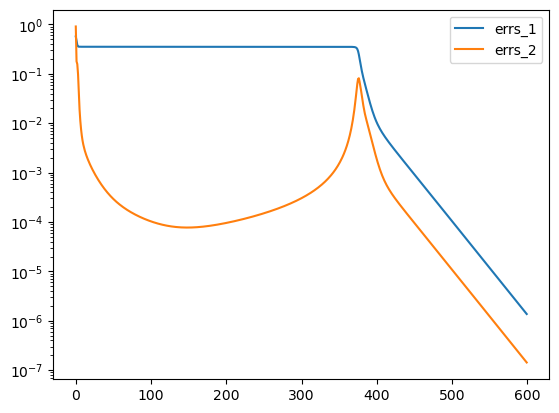

In [11]:
seed = 3
np.random.seed(seed) #3 4

A = np.zeros((4, 4, 4))
A[:, :, 0] = [[1, 0, 0, 0],
              [0, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 0, 0]]
A[:, :, 1] = [[0, 0, 0, 0],
              [1, 0, 0, 0],
              [0, 0, 0, 0],
              [0, 1, 0, 0]]
A[:, :, 2] = [[0, 0, 1, 0],
              [0, 0, 0, 0],
              [0, 0, 0, 1],
              [0, 0, 0, 0]]
A[:, :, 3] = [[0, 0, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 0],
              [0, 0, 0, 1]]
rank = 7

sz = A.shape
U0 = np.random.randn(sz[0], rank)
V0 = np.random.randn(sz[1], rank)
W0 = np.random.randn(sz[2], rank)

X, errs_1, errs_2 = als_multilinear(A, rank, 1e-14, (U0, V0, W0), maxiter=600)

plt.semilogy(errs_1, label='errs_1')
plt.semilogy(errs_2, label='errs_2')
plt.legend();

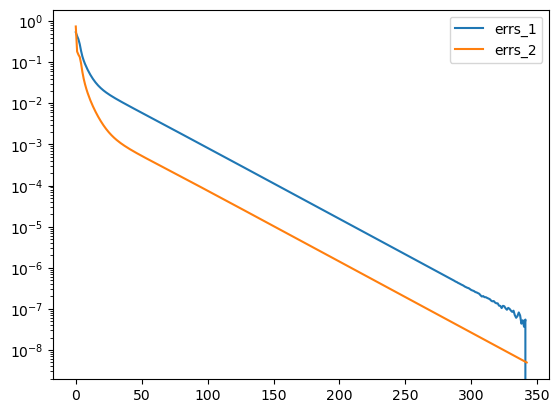

In [12]:
seed = 2
np.random.seed(seed) #3 4

A = np.zeros((4, 4, 4))
A[:, :, 0] = [[1, 0, 0, 0],
              [0, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 0, 0]]
A[:, :, 1] = [[0, 0, 0, 0],
              [1, 0, 0, 0],
              [0, 0, 0, 0],
              [0, 1, 0, 0]]
A[:, :, 2] = [[0, 0, 1, 0],
              [0, 0, 0, 0],
              [0, 0, 0, 1],
              [0, 0, 0, 0]]
A[:, :, 3] = [[0, 0, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 0],
              [0, 0, 0, 1]]
rank = 7

sz = A.shape
U0 = np.random.randn(sz[0], rank)
V0 = np.random.randn(sz[1], rank)
W0 = np.random.randn(sz[2], rank)

X, errs_1, errs_2 = als_multilinear(A, rank, 1e-14, (U0, V0, W0), maxiter=600)

plt.semilogy(errs_1, label='errs_1')
plt.semilogy(errs_2, label='errs_2')
plt.legend();

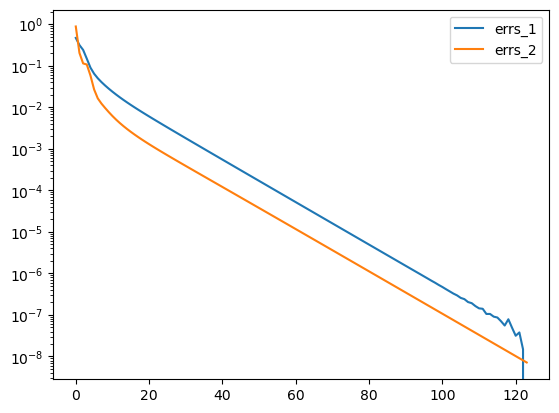

In [13]:
seed = 1
np.random.seed(seed) #3 4

A = np.zeros((4, 4, 4))
A[:, :, 0] = [[1, 0, 0, 0],
              [0, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 0, 0]]
A[:, :, 1] = [[0, 0, 0, 0],
              [1, 0, 0, 0],
              [0, 0, 0, 0],
              [0, 1, 0, 0]]
A[:, :, 2] = [[0, 0, 1, 0],
              [0, 0, 0, 0],
              [0, 0, 0, 1],
              [0, 0, 0, 0]]
A[:, :, 3] = [[0, 0, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 0],
              [0, 0, 0, 1]]
rank = 7

sz = A.shape
U0 = np.random.randn(sz[0], rank)
V0 = np.random.randn(sz[1], rank)
W0 = np.random.randn(sz[2], rank)

X, errs_1, errs_2 = als_multilinear(A, rank, 1e-14, (U0, V0, W0), maxiter=600)

plt.semilogy(errs_1, label='errs_1')
plt.semilogy(errs_2, label='errs_2')
plt.legend();

In [23]:
import tensorly
weight_opt, X_opt =  tensorly.decomposition.parafac(A, rank, n_iter_max=600, tol = 1e-14)

In [24]:
np.linalg.norm(A - full(X_opt))

5.389697896254634e-07

In [25]:
np.linalg.norm(A - full(X))

8.897482063905814e-08

В ручную написанный метод оказался лучше, чем библиотечный. Из графиков обучения следует, что метод нелокальный. От начального приближения завичит момент в который метод выходит на линйеный уровень сходимости. Это показывает график при $seed = 3$, шде до 400 шага метод не сходился, пока не попал в окрестность оптимума, после чекго стал сходится линйено. В тех же случаях, где "угадали" с решением метод сразу стал сходится линейно 

# 2. Применение CP разложения для обработки данных электроэнцефалограммы (ЭЭГ)

В этой задаче мы запустим алгоритм на открытых [данных ЭЭГ](http://archive.ics.uci.edu/ml/datasets/EEG+Database), использующихся для изучения особенностей ЭЭГ при алкогольной зависимости. Датасет включает в себя измерения энцефалограммы на частоте 256 Гц с 64 электродов (число каналов), расположенных на голове 119 пациентов (76 с алкогольной зависимостью и 43 контрольных пациента) и записанные в течение 1 секунды после показа некоторого изображения. Данные обработаны и приведены к виду тензора с помощью открытого [кода](https://github.com/kharyuk/vbtd) из [статьи](https://link.springer.com/article/10.1134/S0965542521050146) и находятся в файле ```smni_eeg.npz```. Произведем их выгрузку. [Ссылка на данные](https://yadi.sk/d/LVf_R3MK0j7pAA).

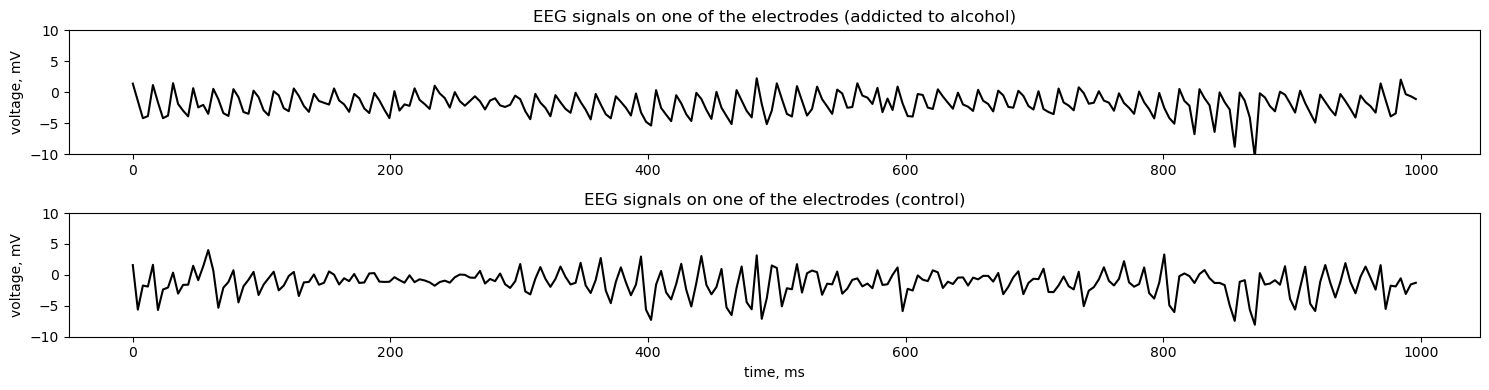

In [58]:
processed_filename = 'smni_eeg_processed.npz'
df = np.load(processed_filename)
data, labels = df['data'], df['labels']

Nsubjects, Nchannels, Ntime, Nconditions = data.shape

# For simplicity we will only use 1 condition out of 3 and take every second electrode
data = data[:, ::2, :, 0]

sample_frequency = 256 # Hz
timepoints = 1000.0 * np.arange(Ntime) / sample_frequency # ms

ind_alcohol = list(np.where(labels == 0)[0])[:10] #[:10] is to make tensor smaller
ind_control = list(np.where(labels == 1)[0])[:10] #[:10] is to make tensor smaller

fig, ax = plt.subplots(2, 1, figsize=(15, 4))

ax[0].plot(timepoints, data[ind_alcohol[2], 4, :].T, color='k');
ax[1].plot(timepoints, data[ind_control[2], 4, :].T, color='k');

ax[1].set_xlabel('time, ms');
ax[0].set_ylabel('voltage, mV');
ax[1].set_ylabel('voltage, mV');
ax[0].set_title('EEG signals on one of the electrodes (addicted to alcohol)');
ax[1].set_title('EEG signals on one of the electrodes (control)');
ax[0].set_ylim([-10, 10])
ax[1].set_ylim([-10, 10])
plt.tight_layout()

Теперь подготовим данные. Для этого по временной координате возьмем оконное преобразование Фурье (short-time Fourier transform, STFT). STFT соответствует разбиению временного интервала на несколько пересекающихся сегментов и применению к каждому из них преобразования Фурье, что позволяет улавливать изменение частоты сигнала от времени. В итоге мода размера Ntime ращепится на 2 составляющие: число сегментов и частота в каждом из сегментов. Для избежания комплесных чисел и упрощения модели мы рассмотрим абсолютные значения тензора.

In [125]:
axis = -1 # timepoints
sample_rate = 256 # 256 Hz
nperseg = 256 # number of points per segment

f, t, A = scipy.signal.stft(data, fs=sample_rate, window='hann', 
                            nperseg=nperseg, noverlap=None, nfft=None, 
                            detrend=False, return_onesided=True, 
                            boundary='zeros', padded=True, axis=axis)

A = np.abs(A)

sz = A[0, :, :, :].shape

Напишем функцию ```normalize```, эквивалентно представляющую тензор $A = [[U, V, W]]$ в виде:
$$
  A = \sum_{\alpha=1}^R s_\alpha\, u_\alpha \circ v_\alpha \circ w_\alpha, \quad \|u_\alpha\|_2 = \|v_\alpha\|_2 = \|w_\alpha\|_2 = 1
$$
с отсортированными по убыванию значениями $s_\alpha$. Далее мы будем анализировать значения $s_\alpha$ -- величина вклада соответствующей компоненты ранга 1 в итоговую сумму.

Напишите функцию ```normalize```.

In [116]:
def normalize(X):
  '''
    Input:
        X: (U, V, W) tuple
    
    Output:
        s: array, containing norms of rank-1 terms in the descending order
        (U, V, W): tuple with the respective canonical factors
  '''
  U, V, W = X
  u_norm = np.linalg.norm(U, axis=0)
  v_norm = np.linalg.norm(V, axis=0)
  w_norm = np.linalg.norm(W, axis=0)
  s = u_norm * v_norm * w_norm
  arg_s = np.flip(np.argsort(s))
  U = U[:, arg_s] / u_norm
  V = V[:, arg_s] / v_norm
  W = W[:, arg_s] / w_norm 
  s = s[arg_s]
  return s, (U, V, W)

Запустим ALS метод для одного из пациентов для разных значений рангов (и для ускорения вычислений взяв в 2 раза меньше электродов). Объясните наблюдаемое поведение сходимости для все значений рангов. Предложите, что нужно изменить в коде для ALS, чтобы избежать наблюдаемых проблем со сходимостью при некоторых значениях рангов?

/tmp/ipykernel_668224/1107639078.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  U, U_last = np.linalg.lstsq(expand_krp(V, W).T, mttkrp(A, (V, W), 0).T)[0].T, U
/tmp/ipykernel_668224/1107639078.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  V, V_last = np.linalg.lstsq(expand_krp(U, W).T, mttkrp(A, (U, W), 1).T)[0].T, V
/tmp/ipykernel_668224/1107639078.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To u

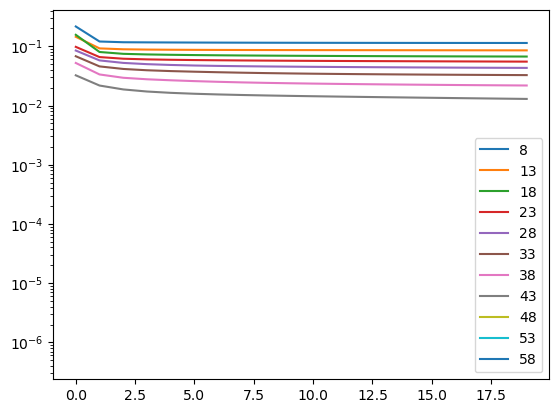

In [148]:
np.random.seed(0)

for rank in range(8, 60, 5):
  U0 = np.random.randn(sz[0]//2, rank)
  V0 = np.random.randn(sz[1], rank)
  W0 = np.random.randn(sz[2], rank)
  
  X, errs_1, errs_2 = als_multilinear(A[0, ::2, :, :], rank, 1e-6, (U0, V0, W0), maxiter=20)
  plt.semilogy(errs_1, label=rank)
  plt.legend()

Разницы сходимомости при разных значениях не было, до 33 ранга методы сходятся линйено до какого-то минимального значения, после чего выходят на плато, скорее всего это связяно с тем, что нет более оптимального разложения для такого ранга. После 33 ранга метод сразу за одну итерацию находит оптимальное разложение. Поэтому сложно пердложит еще что-то улучшающее метод

### Классификация

В качестве признаков для отличия двух классов попробуем использовать простейший вариант – $s_\alpha$ (вклады от компонент ранга 1). Интуитивно кажется, что можно ожидать пониженную активизацию центров активности мозга у людей с положительным диагнозом. Попробуем увидеть эту закономерности для некоторых из значений рангов.

100%|██████████| 20/20 [08:23<00:00, 25.20s/it]


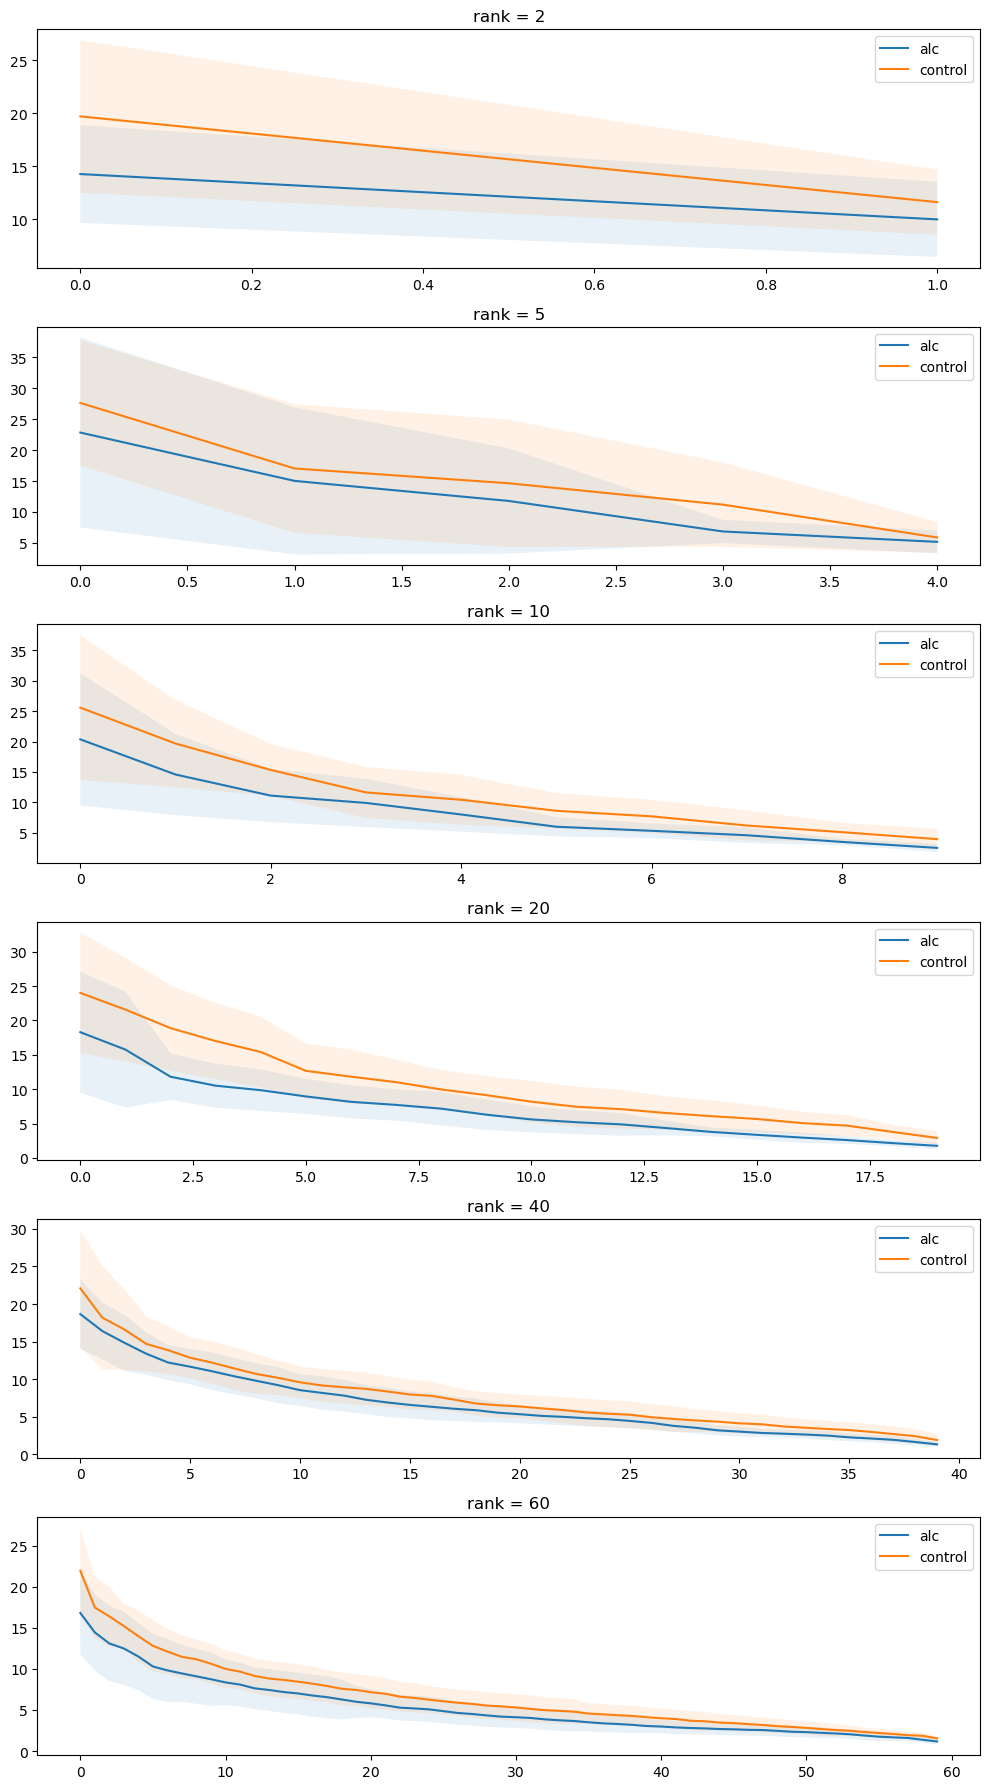

In [151]:
from tqdm import tqdm
ranks = [2, 5, 10, 20, 40, 60]

fig, ax = plt.subplots(len(ranks), 1, figsize=(10, 3*len(ranks)))

np.random.seed(0)

for j, rank in enumerate(ranks):

  U0 = np.random.randn(sz[0], rank)
  V0 = np.random.randn(sz[1], rank)
  W0 = np.random.randn(sz[2], rank)

  s_alc = np.zeros((rank, len(ind_alcohol)))
  s_ctrl = np.zeros((rank, len(ind_control)))

  j_alc = 0
  j_ctrl = 0
  for i in tqdm(ind_alcohol + ind_control):
    B = A[i, :, :, :]
    X, errs_1, errs_2 = als_multilinear(B, rank, 1e-6, (U0, V0, W0), maxiter=100)
    s, X = normalize(X)

    if i in ind_alcohol:
      s_alc[:, j_alc] = s
      j_alc += 1
    else:
      s_ctrl[:, j_ctrl] = s
      j_ctrl += 1

  mean_alc = np.mean(s_alc, axis=-1)
  std_alc = np.std(s_alc, axis=-1)
  ax[j].plot(mean_alc, label='alc')
  ax[j].fill_between(range(len(mean_alc)), mean_alc-std_alc, mean_alc+std_alc, alpha=.1)

  mean_ctrl = np.mean(s_ctrl, axis=-1)
  std_ctrl = np.std(s_ctrl, axis=-1)
  ax[j].plot(mean_ctrl, label='control')
  ax[j].fill_between(range(len(mean_ctrl)), mean_ctrl-std_ctrl, mean_ctrl+std_ctrl, alpha=.1)
    
  ax[j].set_title('rank = {}'.format(rank))

  ax[j].legend()
  
plt.tight_layout()

На практике, конечно, необходимо использовать более серьезные подходы, включающие дополнительные ограничения на факторы разложения, например, неотрицательность факторов, статистическую независимость компонент и т.д., а также анализировать значения в самих факторах. Подробнее с этим приложением можно ознакомиться, например, в статье [Tensor decomposition of EEG signals: A brief review, F. Cong et al., 2015](https://www.sciencedirect.com/science/article/pii/S0165027015001016)

На урвоне значимости значения факторов при отсутвии алкогольной зависимости выше, причем это наблюдается вне зависимотси от порчядка этого фактора